# Mini 8. Heart Attack Analysis & Prediction
[Data Information]   
Data Source: https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset?select=heart.csv   
Data Name : 'heart.csv'   
Data Format : (303, 14)   

[Description]   
 A dataset for heart attack classification   
 Hone your analytical and ML skills by participating in tasks of my other dataset's.   
 Given below.

[Attibutes]   
- Age : Age of the patient
- Sex : Sex of the patient
- exang: exercise induced angina (1 = yes; 0 = no)
- ca: number of major vessels (0-3)
- cp : Chest Pain type chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- trtbps : resting blood pressure (in mm Hg)
- chol : cholestoral in mg/dl fetched via BMI sensor
- fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- rest_ecg : resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach : maximum heart rate achieved
- target :
    - 0= less chance of heart attack
    - 1= more chance of heart attack

## 0. Setting

### 라이브러리 호출

In [7]:
# 라이브러리 호출
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import time
import datetime as dt

# 한글 폰트 패치.
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False  

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# ggplot style skima
plt.style.use("ggplot")

# seaborn plot style definition
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# sklearn.module
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from  sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC ,LinearSVC
from sklearn.ensemble import  RandomForestClassifier ,AdaBoostClassifier ,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import  GaussianNB
# from xgboost import XGBoostClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, precision_recall_curve

### 시각화 한글 폰트 설정

In [8]:
import platform

def get_font_family():
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

%config InlineBackend.figure_format = 'retina'

plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

get_font_family()

'AppleGothic'

### 사용자 정의 함수

In [9]:
# IQR Based Outlier Processing Function Definition
def outlier_process(x):
    upper, lower= np.quantile(x,0.75), np.quantile(x,0.25)
    iqr = upper-lower
    upper_line, lower_line = upper + iqr*1.5, lower - iqr*1.5
    print(x.name,'boundary :',np.round((lower_line,upper_line),4))
    return x.clip(lower_line,upper_line)

# Boxplot EDA Function Definition
def boxplotEDA(data,cols,nrow,ncol,title):
    df = data[cols]
    fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol,4*nrow))
    fig.suptitle(title,size=20)
    i=0
    for col in cols:
        sns.boxplot(y = df[col], ax=ax[i//ncol,i%ncol], linewidth=1.5)
        i+=1 

# ML GridSearchCV
def ML_search(X_train,y_train,X_test,y_test):
    lr = LogisticRegression(random_state=42)
    svm = SVC(random_state=42)
    rf  = RandomForestClassifier(random_state=42)
    dt = DecisionTreeClassifier(random_state=42)
    gus = GaussianNB()
    knn = KNeighborsClassifier()
    lin_svc = LinearSVC(random_state=42)
    ada = AdaBoostClassifier(random_state=42)
    grd  = GradientBoostingClassifier(random_state=42)
    lgbm = LGBMClassifier(random_state=42)
    
    models = [lr, svm, rf, dt, gus, knn, lin_svc, ada, grd, lgbm]
    models_result = []
    
    for model in models:
        model.fit(X_train,y_train)
        pred = model.predict(X_test)
        pre = precision_score(y_test,pred)
        rec = recall_score(y_test,pred)
        f1 = f1_score(y_test,pred)
        acc = accuracy_score(y_test,pred)
        models_result.append([model,acc,f1,pre,rec])
        
    df = pd.DataFrame(models_result, columns=['name','acc','f1','precision','recall'])
    return df

# Get Clf Evaluation Metrics
def get_clf_eval(y_test,pred):
    cf = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    rec = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    
    print(cf)
    print('정확도 :{0:.4f}, 정밀도 :{1:.4f}, 재현율 :{2:.4f}, F1 :{3:.4f}'.format(acc,pre,rec,f1))
    # return [acc, pre, rec, f1]        
        
# 정확도 재현율 곡선
def precision_recall_curve_plot(y_test,pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    plt.axvline(x=0.5, label='Normal Threshold', linestyle=':', alpha=0.8, color='green')
    
    start,end = plt.xlim()
    plt.title('Precision Recall Curve', size=20)
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# ROC 곡선 
def roc_curve_plot(y_test, pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1],linestyle='--', label='Random', color='k')
    
    start, end = plt.xlim()
    plt.title('Roc Auc Curve', size=20)
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1 - Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()

## 1. Data Load
### heart.csv (303, 14)

In [10]:
# Data Load
heart = pd.read_csv('../data/heart.csv')
print('heart.shape :',heart.shape)
heart.head()

heart.shape : (303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [11]:
# Data Info
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [12]:
# Category Data Elements
cat_col = ['sex','cp','fbs','restecg','exng','slp','caa','thall']
for col in cat_col:
    print(col + ':',sorted(heart[col].unique()))

sex: [0, 1]
cp: [0, 1, 2, 3]
fbs: [0, 1]
restecg: [0, 1, 2]
exng: [0, 1]
slp: [0, 1, 2]
caa: [0, 1, 2, 3, 4]
thall: [0, 1, 2, 3]


In [13]:
# Numeric Data List
num_col = ['age','trtbps','chol','thalachh','oldpeak']

In [14]:
# Target Data Value Counts
heart['output'].value_counts()

1    165
0    138
Name: output, dtype: int64

[Data Type Summary]
- Numeric : age, trtbps, chol, thalachh, oldpeak
- Category : sex, cp, fbs, restecg, exng, slp, caa, thall
- Target : output

In [15]:
# Data Describe
heart.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


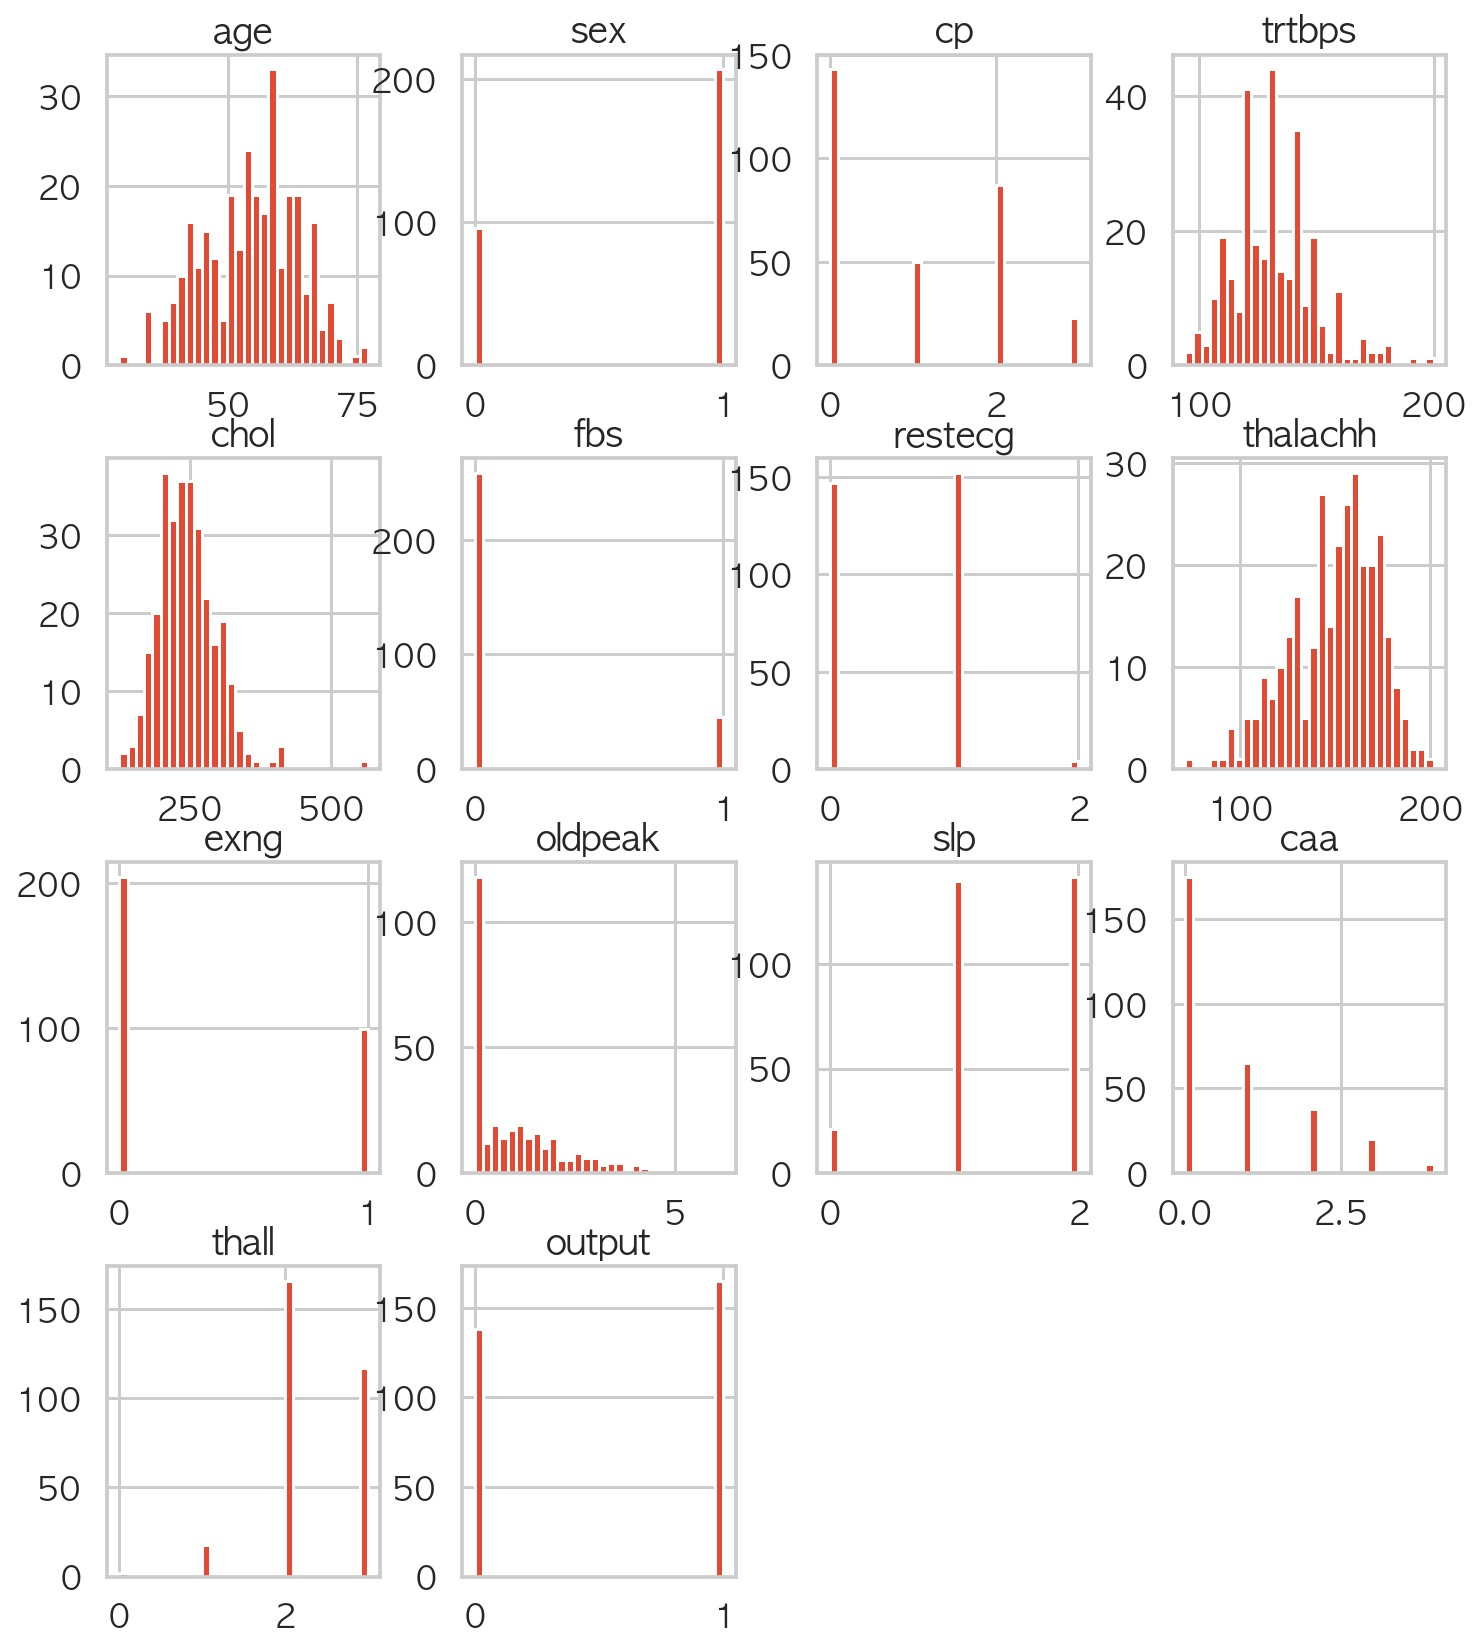

In [16]:
# Histogram Before Preprocessing
_ = heart.hist(figsize=(12,14), bins=30)

## 2. Data EDA & Preprocessing

### Missing Value Imputation

In [17]:
print('Sum of Missing Values :',heart.isna().sum().sum())

Sum of Missing Values : 0


### Drop Duplicates

In [18]:
print('Sum of Duplicates :',heart.duplicated().sum())

Sum of Duplicates : 1


In [19]:
heart[heart.duplicated()]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [20]:
heart = heart.drop(164, axis=0).reset_index(drop=True)
heart.shape

(302, 14)

### Outlier Process

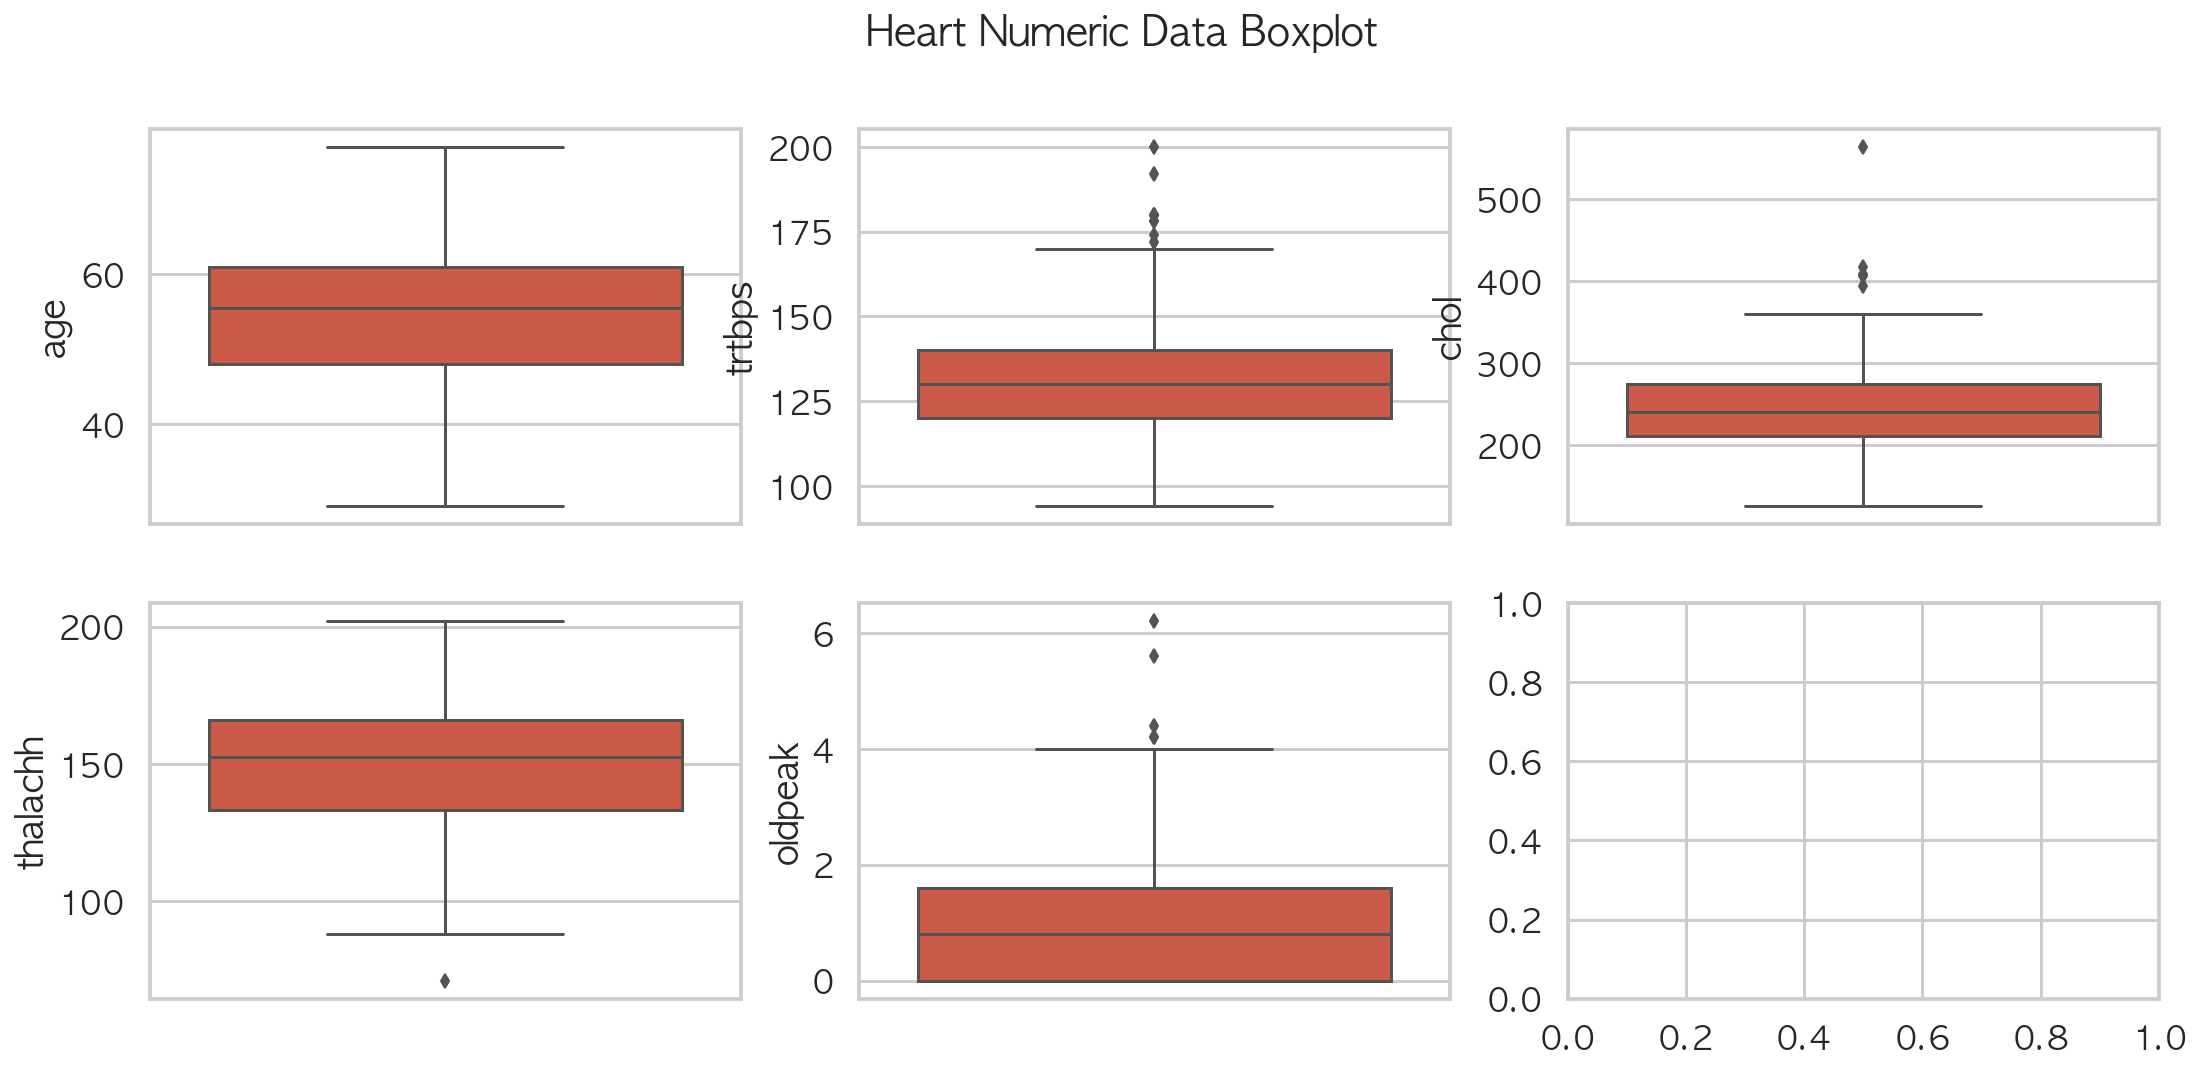

In [21]:
# Boxplot Before Process
boxplotEDA(heart,num_col,2,3,'Heart Numeric Data Boxplot')

In [22]:
# Numeric Data Outlier Process
for col in num_col:
    heart[col] = outlier_process(heart[col])

age boundary : [28.5 80.5]
trtbps boundary : [ 90. 170.]
chol boundary : [115.375 370.375]
thalachh boundary : [ 84.125 215.125]
oldpeak boundary : [-2.4  4. ]


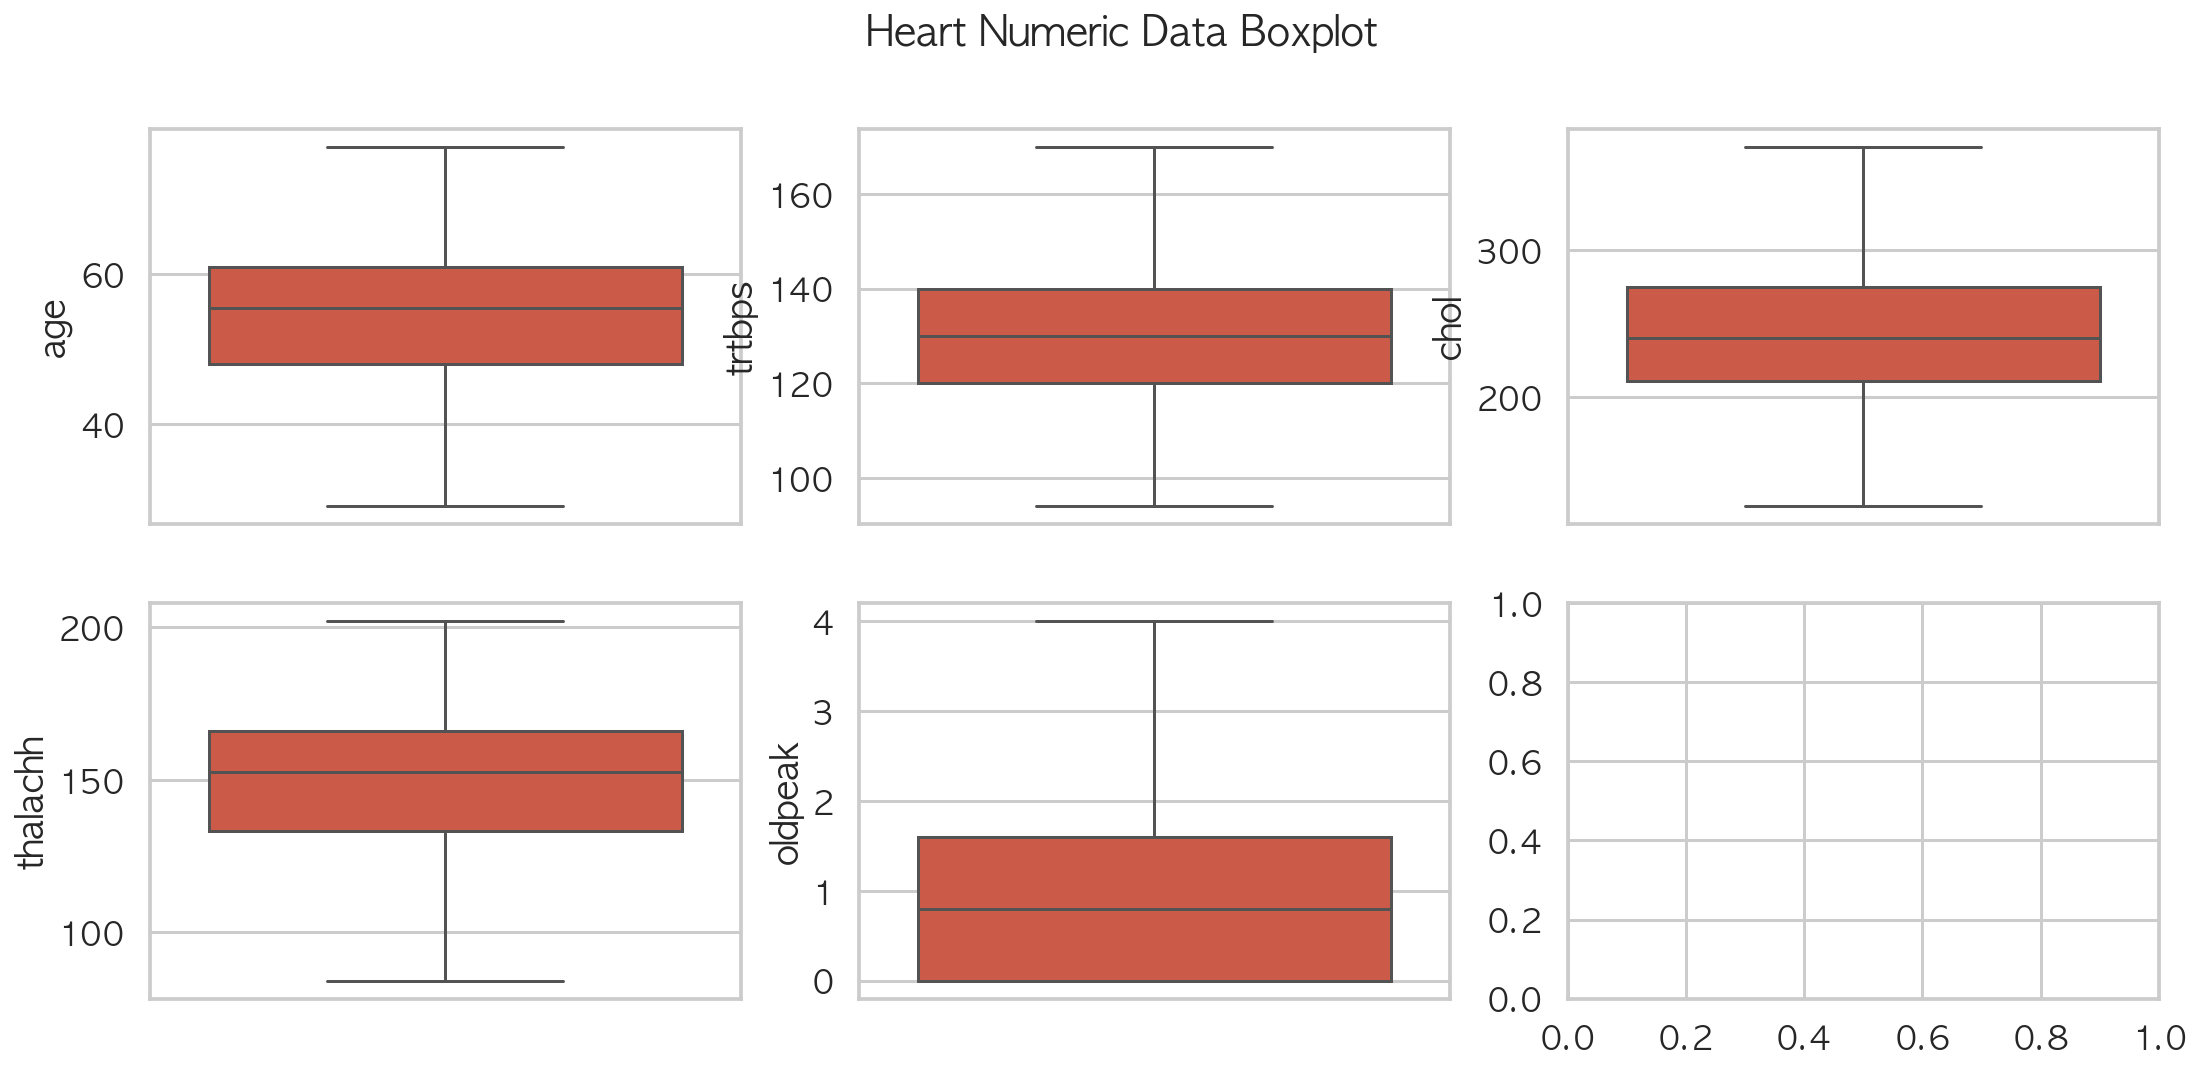

In [23]:
# Boxplot After Process
boxplotEDA(heart,num_col,2,3,'Heart Numeric Data Boxplot')

### Log Transformation

In [24]:
# Numeric Data Log Transformation 
for col in num_col:
    heart[col] = np.log1p(heart[col])

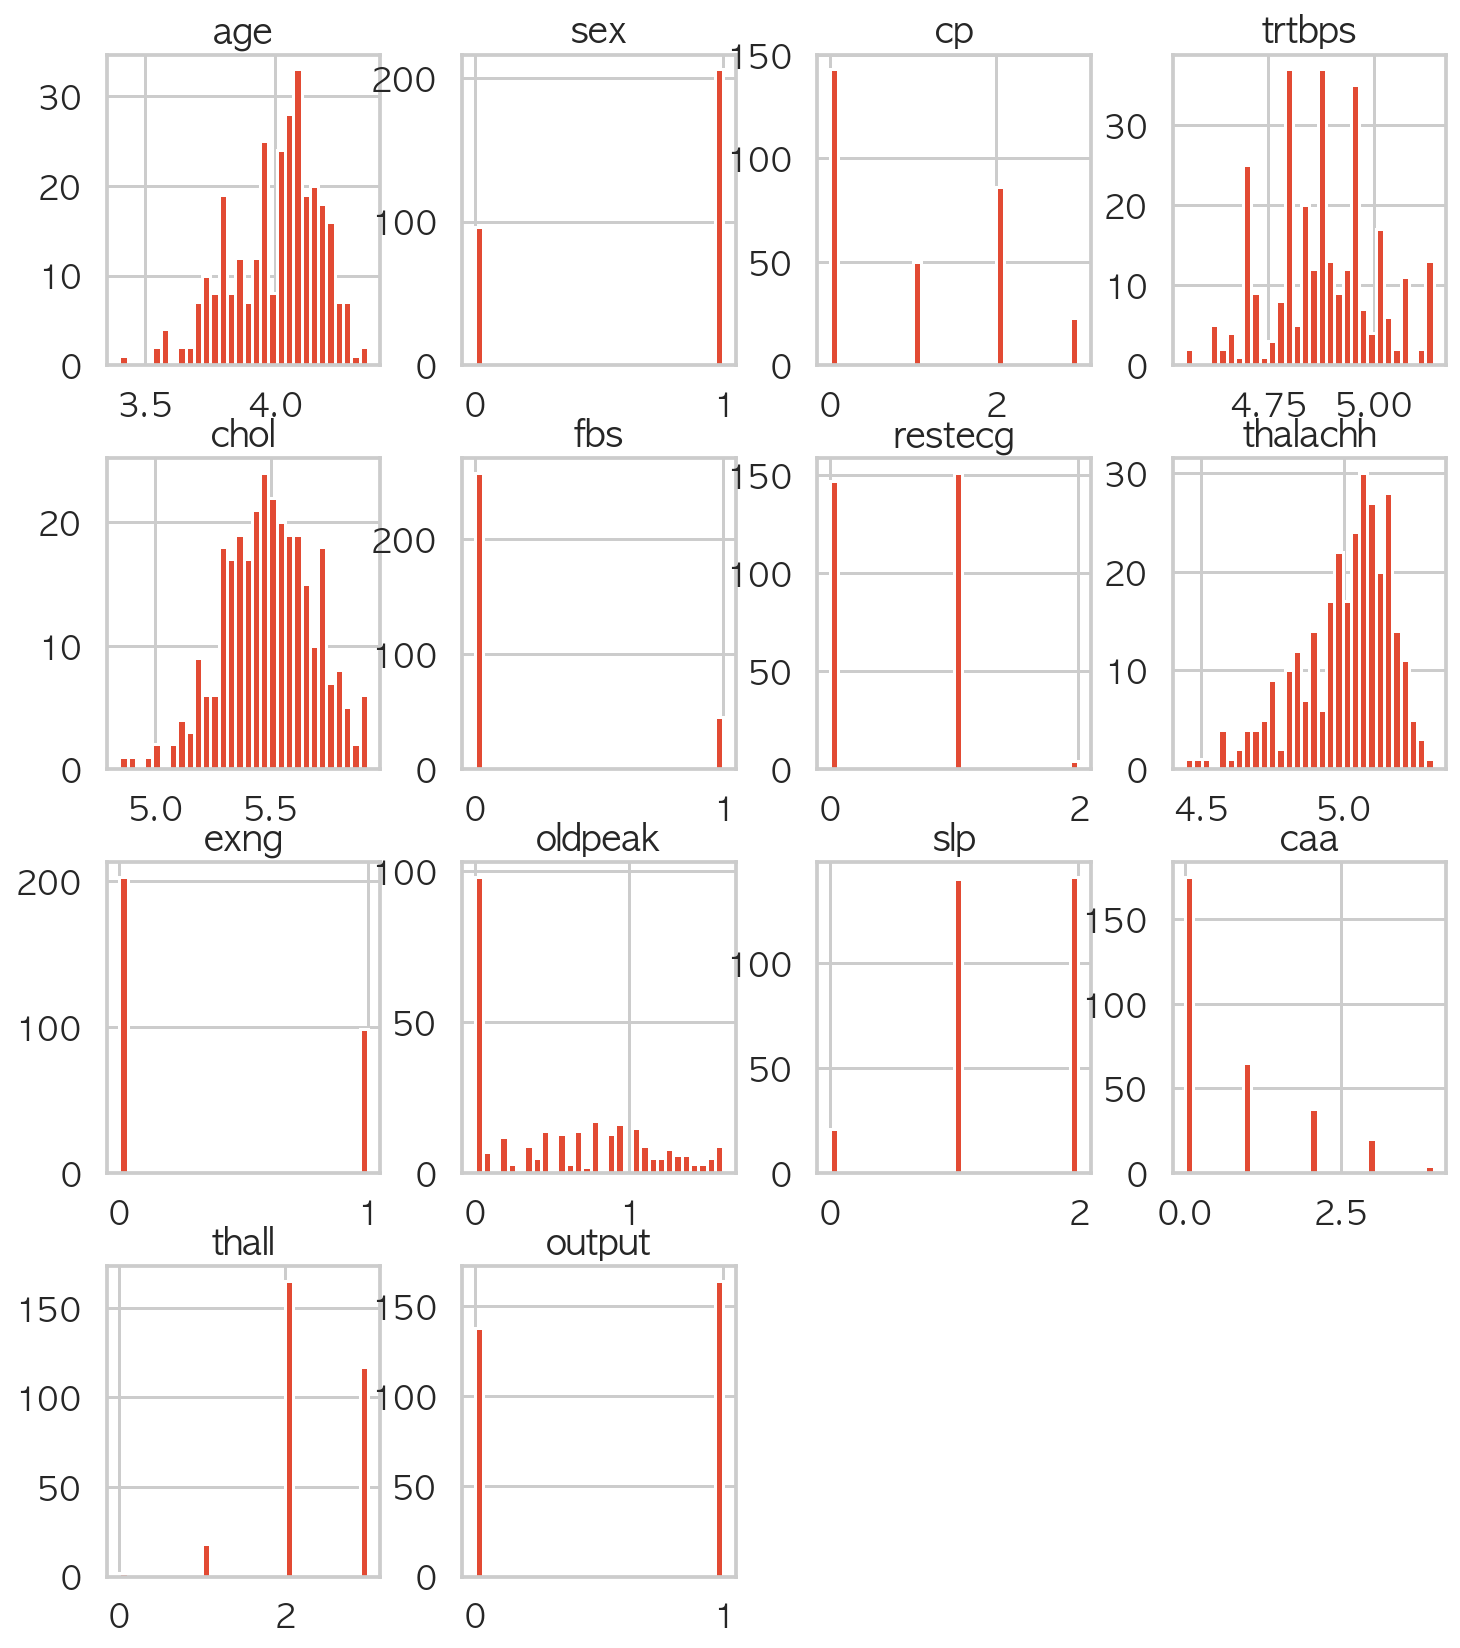

In [25]:
# Histogram After Process
_ = heart.hist(figsize=(12,14), bins=30)

### Correlation Matrix

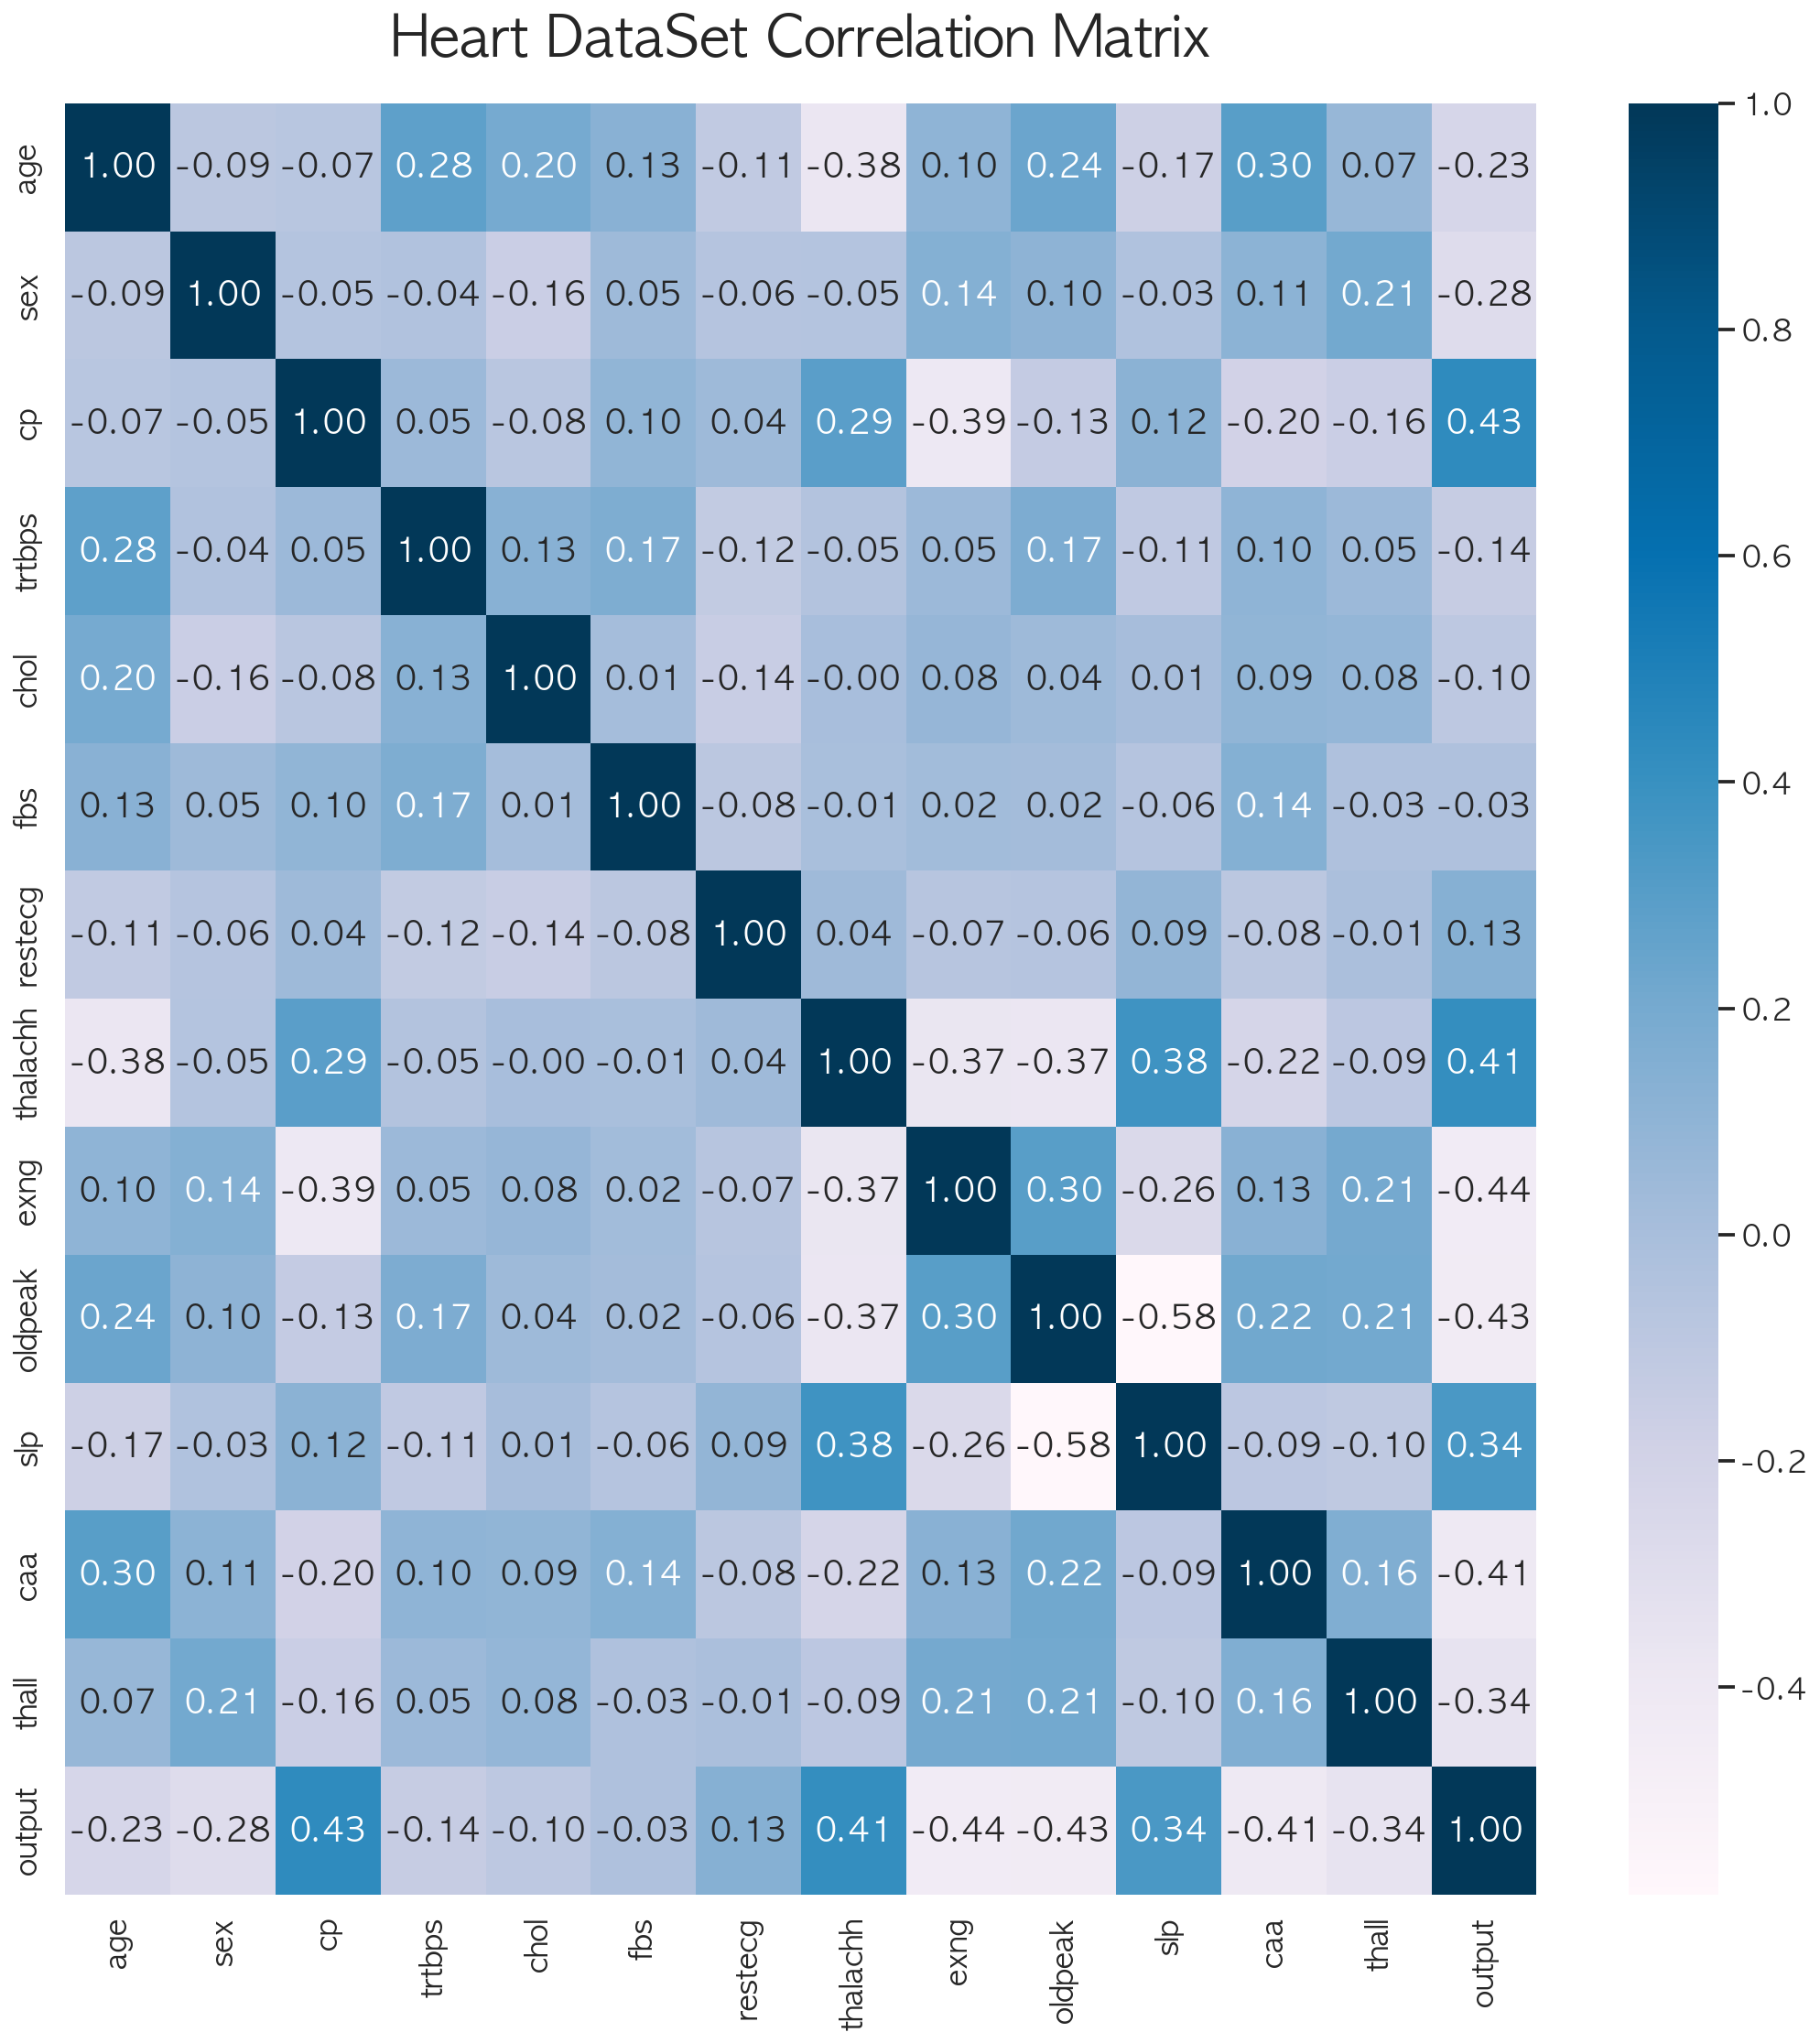

In [26]:
# Correlation Matrix
plt.figure(figsize=(18,18))
sns.heatmap(heart.corr(), cmap='PuBu', annot=True, fmt='.2f')
plt.title('Heart DataSet Correlation Matrix',size=30, y=1.02)
plt.show()

In [27]:
# Top5 Correlation With 'Output'
print(np.abs(heart.corr()['output']).sort_values(ascending=False)[1:5])

exng        0.435601
cp          0.432080
oldpeak     0.430139
thalachh    0.413610
Name: output, dtype: float64


### OneHotEncoding

In [28]:
heart = pd.get_dummies(heart, columns = cat_col, drop_first=True)
heart.head(1)

,age,trtbps,chol,thalachh,oldpeak,output,sex_1,cp_1,cp_2,cp_3,...,exng_1,slp_1,slp_2,caa_1,caa_2,caa_3,caa_4,thall_1,thall_2,thall_3
0,4.158883,4.983607,5.455321,5.01728,1.193922,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


### Standardization

In [29]:
# Standardization
scaler = StandardScaler()
X = heart.drop('output',axis=1)
X_scaled = scaler.fit_transform(X)
y = heart['output']

### Data Split

In [30]:
# Train_Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

print('X_train.shape :',X_train.shape)
print('y_train.shape :',y_train.shape)
print('X_test.shape :',X_test.shape)
print('y_test.shape :',y_test.shape)

X_train.shape : (241, 22)
y_train.shape : (241,)
X_test.shape : (61, 22)
y_test.shape : (61,)


## 3. Modeling

### ML Model Selection

In [31]:
# Best ML Model Search
model_search = ML_search(X_train, y_train, X_test, y_test)
model_search.sort_values(by='acc',ascending=False)[:4]

,name,acc,f1,precision,recall
0,LogisticRegression(random_state=42),0.868852,0.882353,0.857143,0.909091
6,LinearSVC(random_state=42),0.836066,0.857143,0.810811,0.909091
4,GaussianNB(),0.819672,0.835821,0.823529,0.848485
1,SVC(random_state=42),0.803279,0.828571,0.783784,0.878788


### HyperParameter Tuning

In [32]:
# LogisticRegression Model Training
lr_clf = LogisticRegression(random_state=42)

param_grid = {
    'C' : np.logspace(-4, 4, 50),
    'penalty' : ['l1', 'l2']
}

start_time = time.time()
grid_cv = GridSearchCV(lr_clf, cv=3, refit=True, param_grid=param_grid, n_jobs=-1, scoring = 'accuracy')
grid_cv.fit(X_train, y_train)
end_time = time.time()

In [33]:
# Training Time Measurements
duration = end_time - start_time
result = dt.timedelta(seconds=duration)
print('Training Time :',str(result).split('.')[0])

Training Time : 0:00:05


In [34]:
# GridSearchCV Result
score_df = pd.DataFrame(grid_cv.cv_results_)
score_df[['params','mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head(3)

,params,mean_test_score,rank_test_score
31,"{'C': 0.02811768697974228, 'penalty': 'l2'}",0.867438,1
33,"{'C': 0.040949150623804234, 'penalty': 'l2'}",0.863272,2
29,"{'C': 0.019306977288832496, 'penalty': 'l2'}",0.863272,2


In [35]:
# Best HyperParameter & Score
print('best HyperParameter :',grid_cv.best_params_)
print('best Grid_CV Score :',np.round(grid_cv.best_score_,4))

best HyperParameter : {'C': 0.02811768697974228, 'penalty': 'l2'}
best Grid_CV Score : 0.8674


In [36]:
# Best Estimator
best_est = grid_cv.best_estimator_

In [37]:
# LogisticRegression coefficients 
feature_imp = pd.Series(data = best_est.coef_[0], index = X.columns)
feature_imp[:4]

age        -0.050459
trtbps     -0.095122
chol       -0.167476
thalachh    0.182040
dtype: float64

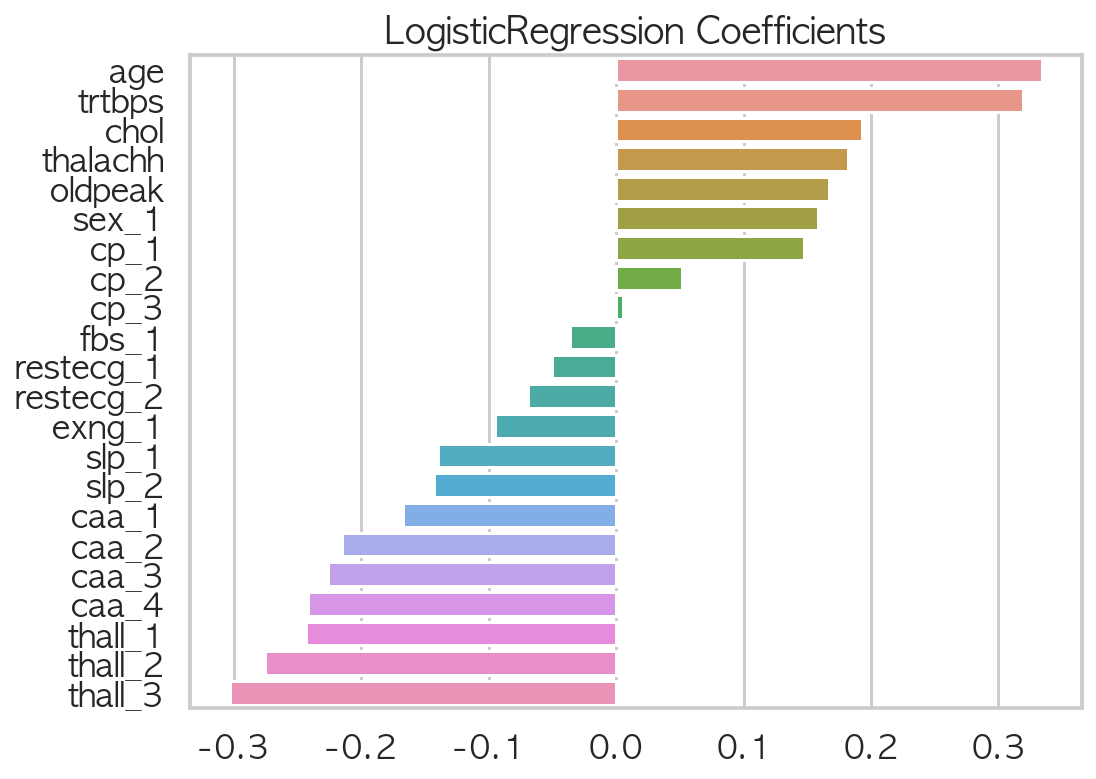

In [38]:
# Coefficient Importances Visualization
plt.figure(figsize=(8,6))
sns.barplot(x=feature_imp.sort_values(ascending=False).values, y=feature_imp.index)
plt.title('LogisticRegression Coefficients')
plt.show()

## 4. Performance Evaluation

In [47]:
y_pred = best_est.predict(X_test)
y_pred

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1])

In [39]:
# Test Data Prediction
y_pred = best_est.predict(X_test)
result = y_test.to_frame().rename(columns={'output':'Truth'})
result['Pred'] = y_pred
print('result.shape :',result.shape)
result.head()

result.shape : (61, 2)


,Truth,Pred
178,0,0
196,0,0
284,0,0
193,0,1
187,0,0


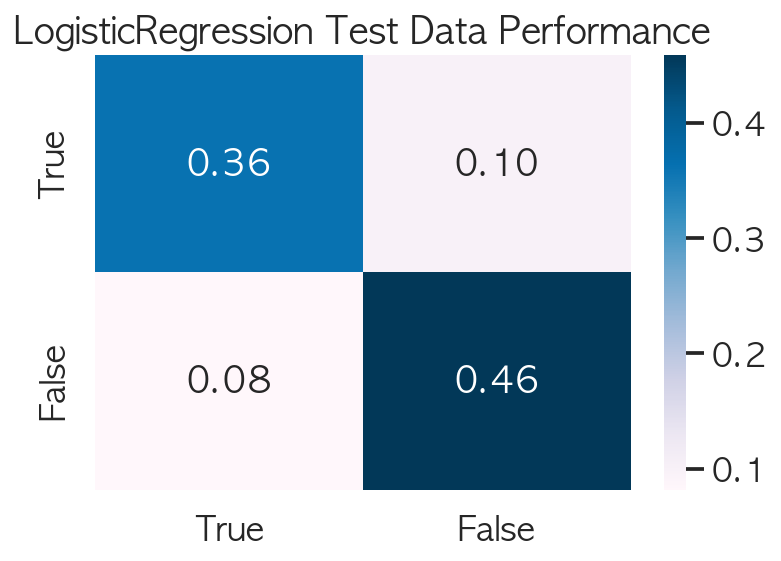

In [40]:
# Test Data Prediction Confusion Matrix
plt.title('LogisticRegression Test Data Performance')
sns.heatmap(confusion_matrix(result['Truth'],result['Pred'],normalize='all'), cmap='PuBu', annot=True, fmt='.2f')
plt.xticks([0.5,1.5],['True','False'])
plt.yticks([0.5,1.5],['True','False'])
plt.show()

In [41]:
# Get Clf Metrics
get_clf_eval(result['Truth'],result['Pred'])

[[22  6]
 [ 5 28]]
정확도 :0.8197, 정밀도 :0.8235, 재현율 :0.8485, F1 :0.8358


In [42]:
# Test Data Prediction Probability
y_pred_proba = best_est.predict_proba(X_test)
y_pred_proba_1 = y_pred_proba[:,1]

Roc Auc Score : 0.8983


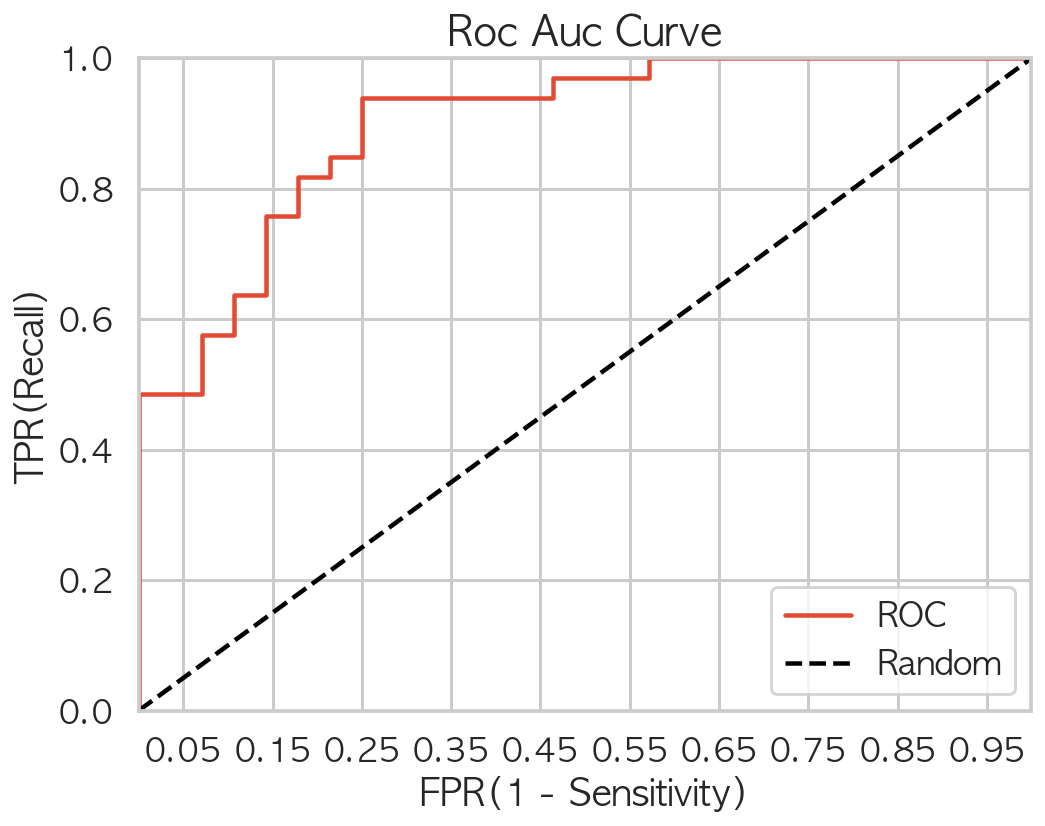

In [43]:
# ROC CURVE
print('Roc Auc Score :',np.round(roc_auc_score(y_test,y_pred_proba_1),4))
roc_curve_plot(y_test, y_pred_proba_1)

Precision : 0.8235
Recall : 0.8485


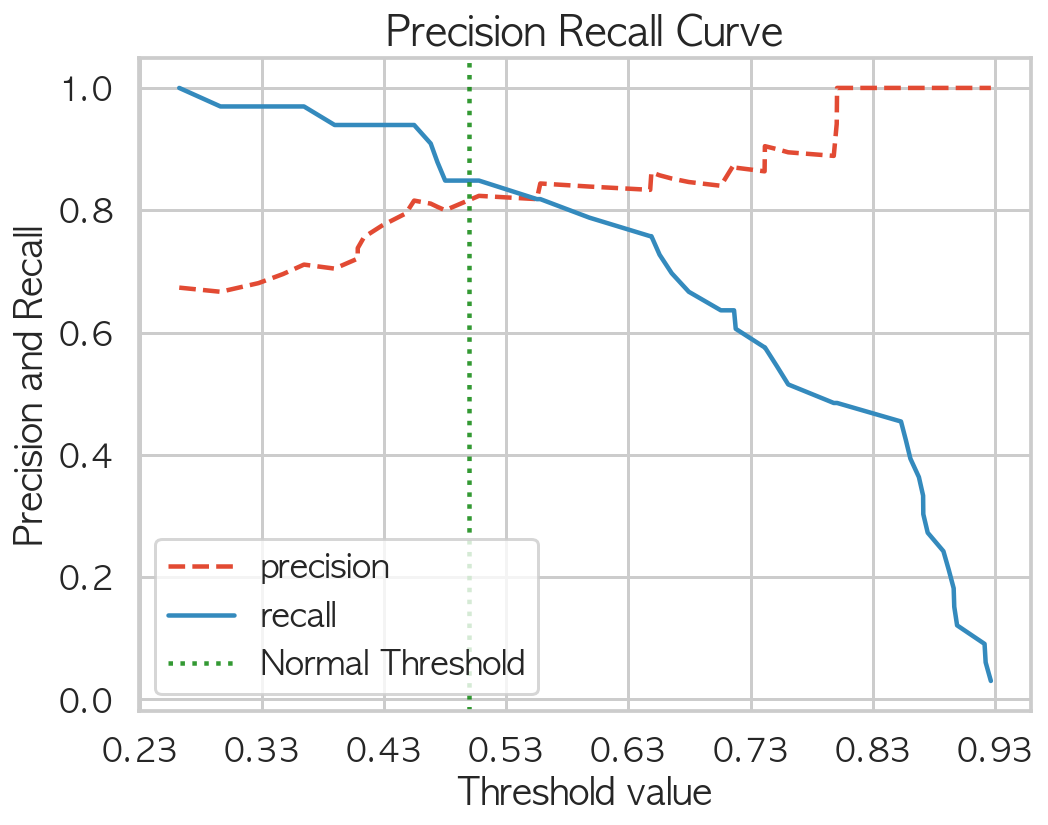

In [44]:
# Precision Recall Curve
print('Precision :',np.round(precision_score(y_test,y_pred),4))
print('Recall :',np.round(recall_score(y_test,y_pred),4))
precision_recall_curve_plot(y_test,y_pred_proba_1)